# Strided TinyYOLOv3 sigma-delta network inference on GPU

This tutorial walks through the GPU inference of trained Strided TinyYOLOv3 SDNN and describe the lava-dl slayer object detection modules along the way.
* Refer to the [README](README.md) for the trainig script
* Refer to [PilotNet SDNN notebook](https://github.com/lava-nc/lava-dl/blob/main/tutorials/lava/lib/dl/slayer/pilotnet/train.ipynb) for an overview of Sigma-Delta networks.

## Object Detection module in Lava-DL
Lava-dl now includes object detection module which can be accessed as `from lava.lib.dl.slayer import obd` or as `slayer.obd`. The object detection module includes
* Base YOLO class `obd.yolo_base` which can be used to design and train YOLO SNNs.
* Pre-formulated model descriptions and pre-trained models `obd.models.{tiny_yolov3_str, yolo_kp}`. In this tutorial we will make use of Strided TinyYOLOv3 SDNN (`obd.models.tiny_yolov3_str`).
* Bounding box metrics and utilities `obd.bbox.{metrics, utils}` to facilitate video object detection training with spiking neurons.
* Dataset modules and utilities `obd.dataset.{BDD, utils}`. Currently there is support for [Berkley Deep Drive (BDD100K)](https://bdd-data.berkeley.edu/) dataset. More dataset support will be added in the future.

__Strided TinyYOLOv3 SDNN__: It is the Sigma-Delta version of TinyYOLOv3 object detection network designed to detect objects in a video stream. The network architecture is tweaked from the TinyYOLOv3[ref] architecture to make the best use of Loihi 2 architecture: the convolution + pool layers are replaced with strided convoltion. The model was trained using the `train_sdnn.py` script included in this folder with initial pre-training on COCO and final training on BDD100K dataset.
```bash
python train_sdnn [complete args]
```


In [1]:
import os
from datetime import datetime
import yaml

import torch
from torch.utils.data import DataLoader

from lava.lib.dl import slayer
from lava.lib.dl.slayer import obd

import ipyplot
import matplotlib.pyplot as plt
from matplotlib import animation, rcParams
import IPython.display as ipd

# Load Inference parameters

YOLO training involves a lot of hyperparameters. The training using `train_sdnn.py` exports training hyperparameter used during the training. `slayer.utils.dotdict` can be used to easily load the hyperparameters and use the same parameters in model fine-tuning as well as inference. In this tutorial we will see `model_args.<param>` being used at various places to initialize the model, dataset, dataloader and so on.

In [2]:
inference_model = 'tiny_yolov3_str'  # Loihi compatible TinyYOLOv3 network
# inference_model = 'yolo_kp'          # Customized model tragetted for 8 chip Kapoho Point form factor

args = slayer.utils.dotdict(load=f'Trained_{inference_model}/network.pt')
trained_folder = os.path.dirname(args.load)
print(trained_folder)

with open(trained_folder + '/args.txt', 'rt') as f:
    model_args = slayer.utils.dotdict(yaml.safe_load(f))
    for (k, v) in model_args.items():
        if k not in args.keys():
            args[k] = v
            
print('Using GPUs {}'.format(args.gpu))
device = torch.device('cuda:{}'.format(args.gpu[0]))
print()
print('Hyperparameters')
print('===============')
for k,v in args.items():
    print(f'{k} : {v}')

Trained_tiny_yolov3_str
Using GPUs [0]

Hyperparameters
load : Trained_tiny_yolov3_str/network.pt
alpha_iou : 0.8
aug_prob : 0.6
b : 1
clamp_max : 5.0
clip : 1.0
dataset : BDD100K
epoch : 200
exp : None
gpu : [0]
label_smoothing : 0.03
lambda_cls : 1.0
lambda_coord : 2.0
lambda_iou : 2.25
lambda_noobj : 4.0
lambda_obj : 1.8
lr : 0.0001
lrf : 0.01
model : tiny_yolov3_str
num_workers : 12
output_dir : .
path : data/bdd100k
scale_grad : 0.2
seed : None
sp_lam : 0.1
sp_rate : 0.01
sparsity : True
subset : False
tau_grad : 0.1
tgt_iou_thr : 0.25
threshold : 0.1
track_iter : 100
verbose : False
warmup : 40
wd : 1e-05


# Load Network Parameters

In the following cell, we will
* Instanciate `obd.models.tiny_yolov3_str.Network` as the desired YOLO SDNN network
* Load the pretrained model parameters into the network

In [3]:
if inference_model == 'tiny_yolov3_str':
    Network = obd.models.tiny_yolov3_str.Network
elif inference_model == 'yolo_kp':
    Network = obd.models.yolo_kp.Network
else:
    raise RuntimeError

net = Network(threshold=model_args.threshold,
              tau_grad=model_args.tau_grad,
              scale_grad=model_args.scale_grad,
              num_classes=11,
              clamp_max=model_args.clamp_max).to(device)
net.init_model((448, 448))
net.load_state_dict(torch.load(args.load))

<All keys matched successfully>

# Create YOLO target

YOLO training requires target tensor generation. Lava-DL object detction module provides `obd.YOLOtarget` to generate the YOLO target for the network on the fly. `obd.YOLOtarget` also includes `collate_fn` method which can be used to stack the samples, targets and ground truth bounding boxes in the dataloader.

In [4]:
yolo_target = obd.YOLOtarget(anchors=net.anchors,
                             scales=net.scale,
                             num_classes=net.num_classes,
                             ignore_iou_thres=model_args.tgt_iou_thr)

# Load Dataset and Dataloader

Here we will make use of `obd.dataset.BDD` to create the required dataset for BDD100K inference. The dataloader is the standard PyTorch dataloader instance. Note the use of `yolo_target.collate_fn` to generate traget YOLO tensors and describe the batch samples stacking strategy.

In [5]:
test_set = obd.dataset.BDD(root=args.path, dataset='track', train=False, randomize_seq=False, seq_len=200)

test_loader = DataLoader(test_set,
                         batch_size=1,
                         shuffle=True,
                         collate_fn=yolo_target.collate_fn,
                         num_workers=4,
                         pin_memory=True)

# Run GPU Inference

GPU inferene of the network follows the standard PyTorch testing iteration through the test_set once. We make use of `obd.bbox.metrics.APstats` module to evaluate mean Averge Precision (mAP) performance of the YOLO SDNN network.

Note the redifinition of accuracy string in `slayer.utils.LearningStats` and it's use in printing the progress interactively.

In [6]:
epoch = 0
stats = slayer.utils.LearningStats(accuracy_str='AP@0.5')
t_st = datetime.now()
ap_stats = obd.bbox.metrics.APstats(iou_threshold=0.5)

for i, (inputs, targets, bboxes) in enumerate(test_loader):
    net.eval()

    with torch.no_grad():
        inputs = inputs.to(device)
        predictions, counts = net(inputs)

        T = inputs.shape[-1]
        
        predictions = [obd.bbox.utils.nms(predictions[..., t]) for t in range(T)]

        for t in range(T):
            ap_stats.update(predictions[t], bboxes[t])

        stats.testing.num_samples += inputs.shape[0]
        stats.testing.correct_samples = ap_stats[:] * stats.testing.num_samples

        processed = i * test_loader.batch_size
        total = len(test_loader.dataset)
        time_elapsed = (datetime.now() - t_st).total_seconds()
        samples_sec = time_elapsed / (i + 1) / test_loader.batch_size
        header_list = [f'Test: [{processed}/{total} ({100.0 * processed / total:.0f}%)]']

        stats_str = f'| {header_list[0]} AP{str(stats).split("AP")[1]}'
        print(f'\rIter:{i}, {samples_sec:.3f}samples/sec {stats_str}', end='')

Iter:199, 1.181samples/sec | Test: [199/200 (100%)] AP@0.5 = 0.19323 

# Visualize results

The lava-dl object detection module also provides visualization utilities which can be used to create video frames and animations of the network output.
* `obd.bbox.utils.mark_bounding_boxes` to mark bounding box to image.
* `obd.bbox.utils.create_frames` to create annotated image frames for a sequence of predictions and ground truth.
* `obd.bbox.utils.create_video` to export the annotated video for a sequence of predictions and ground truth.


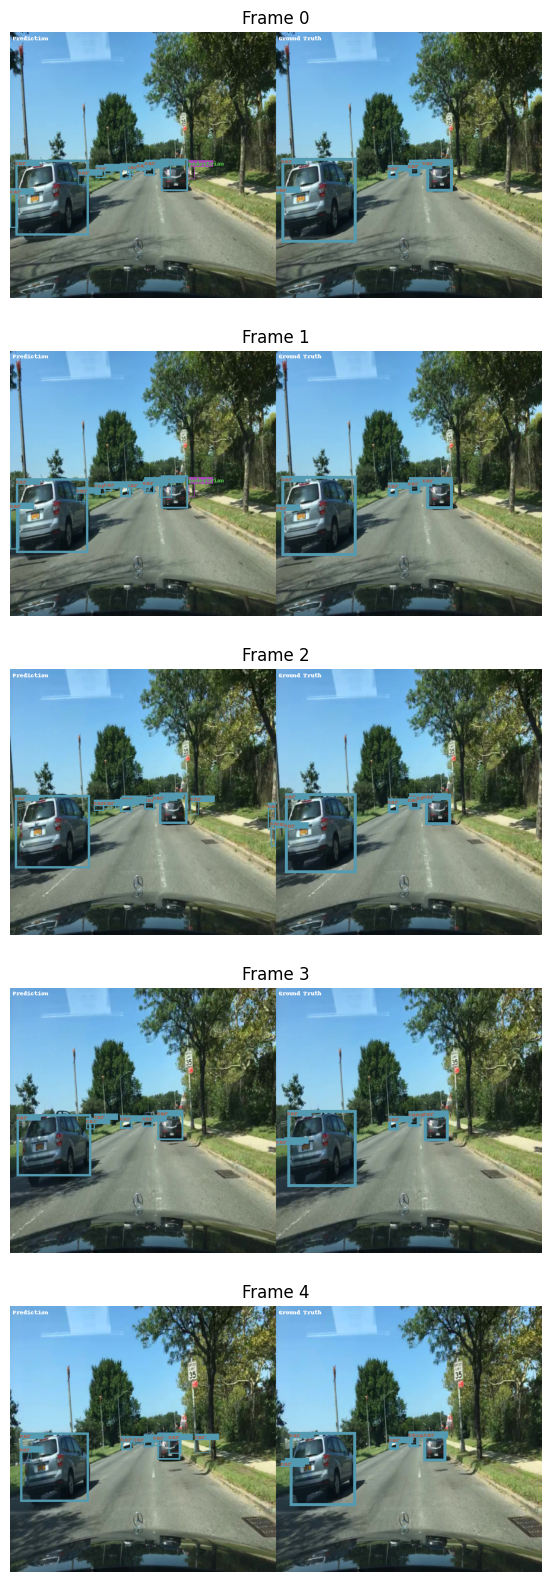

In [7]:
# Visualize a few frames
# obd.bbox.utils.create_video(inputs, bboxes, predictions, 'yolo_output', test_set.classes)
frames = obd.bbox.utils.create_frames(inputs, bboxes, predictions, test_set.classes)
fig, ax = plt.subplots(figsize=(6, 3))
img_plt = ax.imshow(frames[0])
ax.axis('off')

rcParams['animation.embed_limit'] = 1<<20
anim = animation.FuncAnimation(fig, lambda i: img_plt.set_data(frames[i]),
                               frames=len(frames), interval=40, repeat=True)
plt.close(fig)

num_frames = 5
fig, ax = plt.subplots(num_frames, 1, figsize=(8, 4 * num_frames))
for i in range(num_frames):
    ax[i].imshow(frames[i])
    ax[i].axis('off')
    ax[i].set_title(f'Frame {i}')

In [8]:
# Visualize video
anim.save('yolo_output.mp4', writer=animation.FFMpegWriter())
ipd.Video('yolo_output.mp4')